# S

## Funcs

In [2]:
from docplex.cp.model import CpoModel
from docplex.cp.modeler import lexicographic

In [3]:
def read_instance(filename):
    """
    Reads the CVRP instance from a file.

    The file format is assumed to be:
    - The first line contains two numbers: number of customers and best known solution (ignored).
    - The second line contains the vehicle capacity.
    - The third line contains the depot coordinates (x y).
    - The following lines contain customer data: customer number, x, y, demand.

    Returns:
    - capacity: Vehicle capacity.
    - depot_coords: Coordinates of the depot (tuple).
    - customers: List of customer dictionaries with keys 'number', 'x', 'y', 'demand'.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Remove any empty lines or lines with only whitespace
    lines = [line.strip() for line in lines if line.strip()]

    idx = 0
    num_customers, _ = map(float, lines[idx].split())
    num_customers = int(num_customers)
    idx += 1
    capacity = int(lines[idx])
    idx += 1
    depot_coords = tuple(map(int, lines[idx].split()))
    idx += 1

    customers = []
    for _ in range(num_customers):
        customer_info = lines[idx].split()
        idx += 1
        customer_number = int(customer_info[0])
        x = int(customer_info[1])
        y = int(customer_info[2])
        demand = int(customer_info[3])
        customers.append({
            'number': customer_number,
            'x': x,
            'y': y,
            'demand': demand
        })

    return capacity, depot_coords, customers

In [4]:
def compute_distance_matrix(coords):
    """
    Computes the Manhatan distance matrix between all pairs of coordinates.

    Args:
    - coords: List of (x, y) tuples.

    Returns:
    - distance_matrix: 2D list of distances between nodes.
    """
    num_nodes = len(coords)
    distance_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for i in range(num_nodes):
        xi, yi = coords[i]
        for j in range(num_nodes):
            xj, yj = coords[j]
            distance = abs(xi - xj) + abs(yi - yj)
            distance_matrix[i][j] = int(distance)
    return distance_matrix

In [5]:
def solve_cvrp(filename):
    """
    TODO
    """
    
    # Read instance data
    capacity, depot_coords, customers = read_instance(filename)
    num_customers = len(customers)
    C = list(range(1, num_customers + 1))  # Customers are indexed from 1 to n
    n = num_customers
    N = [0] + C  # Nodes including depot (0) and customers
    m = n  # Assuming maximum number of vehicles equals number of customers
    M = list(range(m))  # Vehicle indices from 0 to m-1

    # Coordinates for depot and customers
    coords = [depot_coords] + [(c['x'], c['y']) for c in customers]
    distance_matrix = compute_distance_matrix(coords)
    
    # Demands: demands[0] = 0 for depot
    demands = [0] + [customers[i - 1]['demand'] for i in C]
    
    # Create the model
    model = CpoModel()

    # Decision variables
    # succ[k][i]: successor of node i for vehicle k
    succ = []
    for k in M:
        succ_k = model.integer_var_list(len(N), 0, len(N) - 1, name=f'succ_{k}')
        succ.append(succ_k)
    
    # Variables to represent whether vehicle k uses node i (0 or 1)
    use_node = []
    for k in M:
        use_node_k = [model.integer_var(0, 1, name=f'use_{k}_{i}') for i in N]
        use_node.append(use_node_k)
    
    # Vehicle used variables
    vehicle_used = model.integer_var_list(size=len(M), min=0, max=1, name='vehicle_used')

    # Constraints
    # Each customer must be visited exactly once by one vehicle
    for i in C:
        model.add(model.sum([use_node[k][i] for k in M]) == 1)

    # If a vehicle doesn't use a node, then succ[k][i] == i (non-visit)
    # If a vehicle uses a node, then succ[k][i] != i
    for k in M:
        model.add(vehicle_used[k] == model.min(1, model.sum(use_node[k][i] for i in N)))
        for i in N:
            model.add(model.if_then(use_node[k][i] == 0, succ[k][i] == i))
            model.add(model.if_then(use_node[k][i] == 1, succ[k][i] != i))

            model.add(model.if_then(vehicle_used[k] == 1, succ[k][0] != 0))
            model.add(model.if_then(vehicle_used[k] == 0, succ[k][0] == 0))

    # all diff? Probably not needed after subtour elimination
    for k in M:
        model.add(model.all_diff(succ[k]))

     # Vehicle capacity constraints
    for k in M:
        total_demand = model.sum([demands[i] * use_node[k][i] for i in N])
        model.add(total_demand <= capacity)

    # Symmetry breaking: enforce lexicographic order on succession arrays
    for k in range(len(M) - 1):
        model.add(lexicographic(succ[k+1], succ[k]))

    # Subtour constraints: for each vehicle, the visited nodes form a circuit
    for k in M:
        model.add(model.sub_circuit(succ[k]))

    # First, define arc_cost variables
    max_distance = max(max(row) for row in distance_matrix)
    arc_cost = []
    for k in M:
        arc_cost_k = []
        for i in N:
            # Define an integer variable for the arc cost
            arc_cost_k_i = model.integer_var(0, max_distance, name='arc_cost_{}_{}'.format(k, i))
            arc_cost_k.append(arc_cost_k_i)
            # Link arc_cost_k_i to the distance from i to succ[k][i] when use_node[k][i] == 1
            distance_i = distance_matrix[i]  # This is a list of distances from node i to all other nodes
            distance_ij = model.element(distance_i, succ[k][i])  # This is the distance from i to succ[k][i]
            model.add(model.if_then(use_node[k][i] == 1, arc_cost_k_i == distance_ij))
            model.add(model.if_then(use_node[k][i] == 0, arc_cost_k_i == 0))
        arc_cost.append(arc_cost_k)

    # Now, total distance is the sum of all arc costs
    total_distance = model.sum(arc_cost[k][i] for k in M for i in N)
    model.add(model.minimize(total_distance))

    # Solve the model
    solution = model.solve(TimeLimit=120)

    if solution:
        print("Total distance: {:.2f}".format(solution.get_objective_value()))
        routes = []
        for k in M:
            succ_values = [solution.get_value(succ[k][i]) for i in range(len(N))]
            use_values = [solution.get_value(use_node[k][i]) for i in range(len(N))]

            # Extract the route for vehicle k
            route = []
            if any(use_values):
                current_node = 0  # Start from depot (node 0)
                visited = set()
                while True:
                    next_node = succ_values[current_node]
                    print(next_node)
                    if next_node == 0 or next_node == current_node or next_node in visited:
                        break
                    route.append((current_node, next_node))
                    visited.add(next_node)
                    current_node = next_node
                if route:
                    routes.append((k, route))
                    route_nodes = ['Depot'] + ['Customer {}'.format(pair[1]) for pair in route]
                    route_nodes.append('Depot')
                    print("Vehicle {}: Route: {}".format(k + 1, ' -> '.join(route_nodes)))

        # Visualize the results
        return coords, routes, customers
        
        # solution.write()
        # print(distance_matrix[0])
    else:
        print("No solution found within the time limit.")

In [7]:
filename = '../Instances/test_c75.txt'
coords, routes, customers = solve_cvrp(filename)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 17175 variables, 34649 constraints
 ! Presolve      : 225 extractables eliminated
 ! TimeLimit            = 120
 ! Initial process time : 0.59s (0.59s extraction + 0.01s propagation)
 !  . Log search space  : 80825.7 (before), 80825.7 (after)
 !  . Memory usage      : 20.1 MB (before), 20.1 MB (after)
 ! Using parallel search with 16 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0      17175                 -
 + New bound is 0
                      234       1331    1   F     0 != vehicle_used_0
 + New bound is 1
                     1000        472    1   F    24  = arc_cost_24_0
                     1000        438    2         1 != use_22_73
                     1000       2124    3   F     0 != arc_cost_33_32
                     1000        469    

### Vizualization

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

In [9]:
def visualize_routes(coords, routes, customers):

    plt.figure(figsize=(14,12))
    # Uncomment the following line if needed
    # %matplotlib inline

    # Create a graph
    G = nx.DiGraph()

    # Add nodes with positions and labels
    for idx, (x, y) in enumerate(coords):
        if idx == 0:
            G.add_node(idx, pos=(x, y), demand=0, label='Depot')
        else:
            G.add_node(idx, pos=(x, y), demand=customers[idx - 1]['demand'], label='C-{}'.format(idx))

    # Define colors for different vehicles
    num_vehicles = len(routes)
    color_map = plt.cm.get_cmap('tab20', num_vehicles)

    # Prepare a list of edges and their colors
    edge_list = []
    edge_colors = []
    for idx, (k, route) in enumerate(routes):
        color = color_map(idx)
        for from_node, to_node in route:
            edge_list.append((from_node, to_node))
            edge_colors.append(color)
        # Add edge from last node back to depot
        last_node = route[-1][1]
        edge_list.append((last_node, 0))
        edge_colors.append(color)
    print(routes)
    # Add edges to the graph
    G.add_edges_from(edge_list)

    # Get positions and labels
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'label')

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')

    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color=edge_colors, arrows=True, width=2, arrowstyle='-|>', arrowsize=15)

    plt.title('CVRP Solution Visualization', fontsize=16)
    plt.axis('equal')
    plt.show()

[(0, [(0, 72), (72, 53), (53, 4)]), (1, [(0, 61), (61, 69), (69, 5), (5, 57), (57, 70)]), (2, [(0, 49)]), (3, [(0, 46), (46, 7), (7, 6), (6, 73)]), (4, [(0, 37), (37, 45)]), (5, [(0, 36), (36, 71), (71, 38), (38, 10), (10, 9)]), (6, [(0, 35), (35, 59), (59, 66), (66, 18), (18, 56)]), (7, [(0, 34), (34, 16), (16, 64), (64, 60), (60, 74), (74, 68)]), (8, [(0, 33), (33, 43), (43, 23), (23, 22), (22, 28), (28, 67)]), (9, [(0, 32), (32, 40), (40, 39), (39, 3), (3, 24), (24, 63)]), (10, [(0, 31), (31, 55), (55, 25), (25, 50), (50, 44), (44, 51), (51, 52)]), (11, [(0, 30), (30, 41), (41, 42), (42, 62), (62, 48), (48, 47), (47, 54)]), (12, [(0, 26), (26, 27), (27, 21), (21, 1), (1, 2), (2, 75)]), (13, [(0, 17), (17, 29), (29, 20), (20, 19), (19, 14)]), (14, [(0, 13), (13, 15), (15, 8), (8, 11), (11, 65), (65, 58), (58, 12)])]


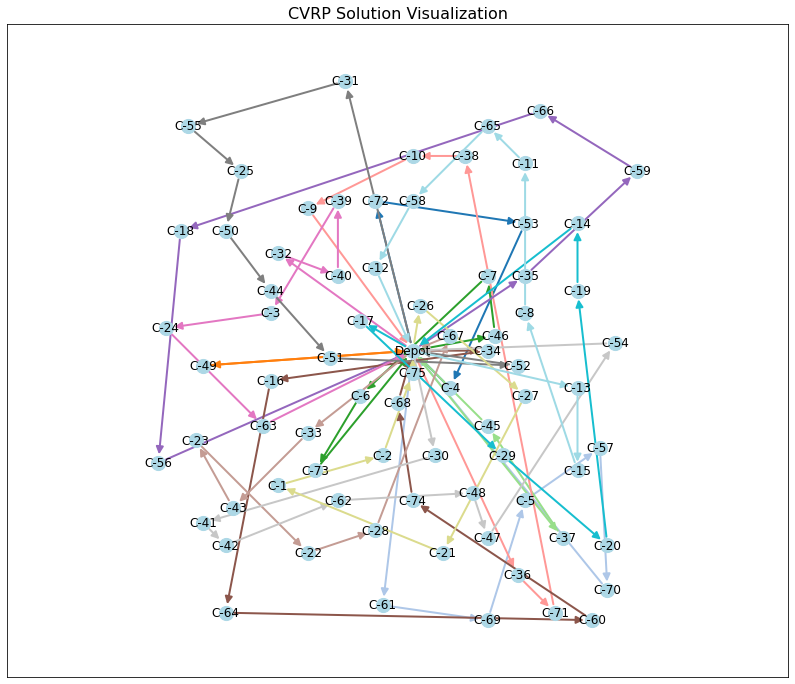

In [10]:
visualize_routes(coords, routes, customers)